#**HOMEWORK: BLUE BIKE TRIP DURATION PREDICTION (Total: / 15 points)**

Context: You have received some data from Blue Bikes (the Boston Bikesharing Service). They have asked you to provide a predictive model that can accurately predict how long a given bike rental will last, at the time the rental begins. The use case is that the bike share company wants to be able to predict how long a customer will have the bike in their possession, when they begin their retnal, in order to better manage operational efficiency across the bike network. Note that when the customer initiates a bike rental, they enter the starting station ID and ending station ID for their trip, into the mobile app.

# *Name: Tao Li*
# *Email: taoli@bu.edu*

#*Import and Pre-process Data*

## Import

In [49]:
import pandas as pd
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from keras import regularizers

## Vectorize Categorical Variables

In [2]:
def vectorize_categorical(sequences, categories_mapping):
    # Make our blank matrix of 0's to store hot encodings.
    results = np.zeros((len(sequences), len(categories_mapping)))

    # For each observation and element in that observation,
    # Update the blank matrix to a 1 at row obs, column element value.
    for i, category in enumerate(sequences):
        results[i, categories_mapping[category]] = 1.
    return results


## Pre-process Dataset

In [147]:
# import dataset
bluebikes = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2023/main/Lecture%20Materials/C_Assignment/bluebikes_sample.csv')

# This function MUST return a pair of objects (predictors, labels, in that order) as numpy arrays.
def processData(data):
    
    # pre-process your data here, and return your two numpy arrays...
    # striptime for all the datetime
    for i, row in data.iterrows():
        # read starttime
        time_str = row['starttime']
        
        # transform time into datatime type
        time_obj = datetime.strptime(time_str, '%M:%S.%f')
        
        # extract minutes and seconds, and calculate the start seconds
        minutes = time_obj.minute
        seconds = time_obj.second + (minutes * 60)
        
        # store start_seconds in the dataset
        data.at[i, 'start_seconds'] = seconds

    # Create mapping for usertype and gender
    usertype_mapping = {value: index for index, value in enumerate(data['usertype'].unique())}
    gender_mapping = {value: index for index, value in enumerate(data['gender'].unique())}

    # Convert categorical features to one-hot encoding
    usertype_onehot = vectorize_categorical(data['usertype'], usertype_mapping)
    gender_onehot = vectorize_categorical(data['gender'], gender_mapping)

    print("Usertype one-hot shape:", usertype_onehot.shape)
    print("Gender one-hot shape:", gender_onehot.shape)

    # Select the relevant features
    #['start_seconds', 'start station id', 'end station id', 
    # 'start station latitude', 'start station longitude', 
    # 'end station latitude', 'end station longitude', 'birth year', 'bikeid']
    # However, 'start_seconds' and 'bikeid' seemed to have negative effects.
    # Merge one-hot features with other features
    predictors = data[['start station latitude', 'start station longitude', 
                       'end station latitude', 'end station longitude', 
                       'birth year']]
    
    # Scale the numerical features
    scaler = StandardScaler()
    numerical_features = scaler.fit_transform(predictors)

    # Merge one-hot features with other features
    # one-hot features 'usertype_onehot' and 
    # 'gender_onehot' has positive effects
    train_predictors = np.concatenate([numerical_features, usertype_onehot, gender_onehot], axis=1)
    train_labels = data['tripduration'].values

    return train_predictors, train_labels


## Check the Dataset

In [137]:
# Check if there is null value in the dataset
bluebikes.isnull().sum()

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
birth year                 0
gender                     0
dtype: int64

In [138]:
# We have 12 features selected in our model in total
# One-hot features are 5 in total
print(bluebikes['usertype'].unique())
print(bluebikes['gender'].unique())

['Subscriber' 'Customer']
[1 2 0]


In [139]:
# Print the head of the dataframe
bluebikes.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1584,09:36.7,36:00.9,442,Hyde Park Ave at Walk Hill St,42.296067,-71.116012,122,Burlington Ave at Brookline Ave,42.345733,-71.100694,4587,Subscriber,1967,1
1,894,40:48.2,55:43.0,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,144,Rogers St & Land Blvd,42.365758,-71.076994,2340,Subscriber,1994,1
2,973,58:05.4,14:18.4,57,Columbus Ave at Massachusetts Ave,42.340543,-71.081388,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,2910,Subscriber,1994,1
3,606,46:45.0,56:51.4,149,175 N Harvard St,42.363796,-71.129164,221,Verizon Innovation Hub 10 Ware Street,42.372509,-71.113054,4526,Subscriber,1992,1
4,428,49:27.9,56:36.7,426,Surface Rd at Summer St,42.352946,-71.056564,420,Charles St at Pinckney St,42.358725,-71.070795,3780,Subscriber,1989,1


In [140]:
# Check the daata type of the dataset
bluebikes.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
dtype: object

In [141]:
# Check the mean, std, min and max to find out the baseline for the loss
bluebikes['tripduration'].describe()

count     9000.000000
mean       849.892444
std       1398.751895
min         61.000000
25%        380.000000
50%        623.500000
75%       1023.000000
max      86912.000000
Name: tripduration, dtype: float64

#*Specify Your Neural Network Architecture, Process Your Sample*

Calling the data pre-processing function on the sample.

In [142]:
predictors, labels = processData(bluebikes)

Usertype one-hot shape: (9000, 2)
Gender one-hot shape: (9000, 3)


Specifying my Neural Network's structure. Note that the important thing for performance with this model actually comes down to its depth! It turns out that width isn't that important here. 


In [124]:
# Can install the tensorflow-addons package in your colab runtime. 
try:
    import tensorflow_addons as tfa                     
except ImportError:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa 

In [152]:
def build_model():
    
    # specify your model architecture here using the Keras sequential API
    # compile your model, specifying the loss and other metrics you might want to track, plus the optimizer

    # Create the neural network model
    # Among 'relu', 'elu', 'tanh' and 'sigmoid', 'elu' seems to work better 
    # than other, and 'tanh' and ' sigmoid' may cause vanishing gradient.
    # 'tanh' and ' sigmoid' approached 400 which is worse than relu and elu
    # I try adding leakyrelu, and random normal noise to the input features, 
    # but it did not work good.

    # After testing 'relu', 'elu', 'tanh', 'leakyrelu' and 'sigmoid', 'elu' 
    # worked best, so start with 'elu' and adding dropout and layers step by 
    # step, to compare them and approach to the best model
    # Tried to add several dropout(0.2-0.5) layers, but some of them seemed 
    # to work worse, so I only left one.
    # After set up dropout layer, I began to increase the num of 
    # units in the first dense layer, but it seemed to work worse
    # After finding the best units number, I began to add an additional 
    # hidden layer, using L1 regularization to prevent overfitting
    model = keras.Sequential([
        keras.layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l1(0.001)),
        keras.layers.BatchNormalization(),
        # After set up dropout layer, I began to add additional dense layer
        keras.layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l1(0.001)),
        keras.layers.Dense(32, activation='elu'),
        # Tried to use dropout(0.2-0.5), it performed the best at 0.2
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='elu'),
        keras.layers.Dense(1, activation='elu')
    ])


    # Compile the model
    # Tries several optimizer, 'rmsprop' and 'adam' with 0.001 learning rate 
    # worked best and approximately same, I chose to use 'rmsprop'
    '''
    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps = 1000,
        decay_rate = 0.9,
        staircase = True
    )

    optimizer = keras.optimizers.Adam(learning_rate = lr_schedule)
    '''
    model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])
    
    return model

#*Train Your Neural Network Here*

In [145]:
model = build_model()

history = model.fit(predictors, labels, epochs=50, batch_size=32, validation_split=0.2) ## specify your data and other parameters here for model fit 

Epoch 1/50
225/225 [==============================] - 3s 6ms/step - loss: 646.1678 - mae: 645.1317 - val_loss: 538.4991 - val_mae: 537.3706
Epoch 2/50
225/225 [==============================] - 1s 4ms/step - loss: 465.1909 - mae: 464.0370 - val_loss: 431.7066 - val_mae: 430.5329
Epoch 3/50
225/225 [==============================] - 1s 4ms/step - loss: 386.3651 - mae: 385.1921 - val_loss: 382.8515 - val_mae: 381.6801
Epoch 4/50
225/225 [==============================] - 1s 5ms/step - loss: 368.0088 - mae: 366.8337 - val_loss: 354.7565 - val_mae: 353.5749
Epoch 5/50
225/225 [==============================] - 1s 6ms/step - loss: 336.7545 - mae: 335.5728 - val_loss: 327.4132 - val_mae: 326.2364
Epoch 6/50
225/225 [==============================] - 2s 7ms/step - loss: 321.4362 - mae: 320.2565 - val_loss: 304.5874 - val_mae: 303.4057
Epoch 7/50
225/225 [==============================] - 1s 5ms/step - loss: 320.5431 - mae: 319.3645 - val_loss: 305.9842 - val_mae: 304.8059
Epoch 8/50
225/225 [

Plot your model performance over training here:

In [148]:
mean_tripduration = bluebikes['tripduration'].mean()
baseline_mae = np.mean(np.abs(mean_tripduration - labels))


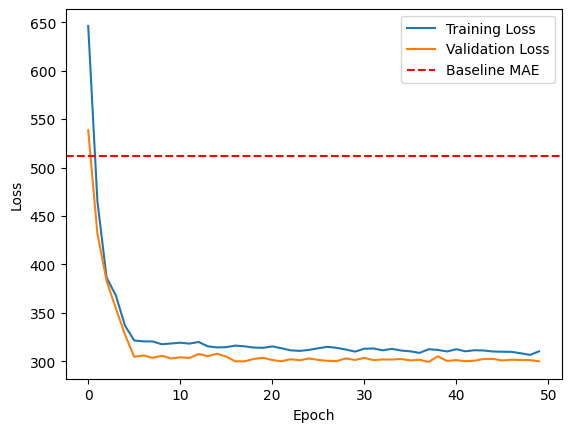

In [149]:
import matplotlib.pyplot as plt

# Build your plot.
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add Baseline MAE
plt.axhline(y=baseline_mae, color='r', linestyle='--', label='Baseline MAE')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.show()

#*Choose Final Configuration and Produce That Model Here:*

In [150]:
model = build_model()
model.fit(predictors,labels,epochs=80, batch_size=50) # for example

Epoch 1/80
180/180 [==============================] - 3s 5ms/step - loss: 672.3986 - mae: 671.3538
Epoch 2/80
180/180 [==============================] - 1s 5ms/step - loss: 520.5709 - mae: 519.3848
Epoch 3/80
180/180 [==============================] - 1s 4ms/step - loss: 479.0006 - mae: 477.8047
Epoch 4/80
180/180 [==============================] - 1s 4ms/step - loss: 460.9399 - mae: 459.7465
Epoch 5/80
180/180 [==============================] - 1s 4ms/step - loss: 450.5657 - mae: 449.3737
Epoch 6/80
180/180 [==============================] - 1s 4ms/step - loss: 404.6885 - mae: 403.4980
Epoch 7/80
180/180 [==============================] - 1s 4ms/step - loss: 373.6439 - mae: 372.4594
Epoch 8/80
180/180 [==============================] - 1s 4ms/step - loss: 366.9534 - mae: 365.7710
Epoch 9/80
180/180 [==============================] - 1s 4ms/step - loss: 343.6759 - mae: 342.4939
Epoch 10/80
180/180 [==============================] - 1s 4ms/step - loss: 320.1147 - mae: 318.9359
Epoch 11/

Here's what the resulting model looks like.

In [151]:
model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_219 (Dense)           (50, 128)                 1408      
                                                                 
 batch_normalization_59 (Bat  (50, 128)                512       
 chNormalization)                                                
                                                                 
 dense_220 (Dense)           (50, 64)                  8256      
                                                                 
 dense_221 (Dense)           (50, 32)                  2080      
                                                                 
 dropout_49 (Dropout)        (50, 32)                  0         
                                                                 
 dense_222 (Dense)           (50, 16)                  528       
                                                     

#*Final Evaluation*

Don't modify this section; this is the code I will use to evaluate that your model is output properly and that it can generate predictions on new test observations it has never seen before. If your model breaks when I feed it the new data, I will deduct marks, so please ensure that your data pre-processing function works properly!

In [ ]:
from google.colab import files
import io

# I'm going to upload my holdout dataset (same set of features)
uploaded = files.upload()
bluebike_holdout = pd.read_csv(io.BytesIO(uploaded['bluebikes_holdout.csv']))

# I'm then going to pre-process it using your commands.
holdout_predictors, holdout_labels = processData(bluebike_holdout)

# Then I'm going to evaluate your model's performance on that data.
loss_metrics = model.evaluate(holdout_predictors,holdout_labels,verbose=1)